In [1]:
!pip install patchify

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import glob
from matplotlib import pyplot as plt

from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
# import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Labels are:  [0 1 2 3 4 5]  and the counts are:  [ 5447007  4944599  2679388 15182061   313148  7433797]
Labels are:  [ 29  76 150 179 226 255]  and the counts are:  [ 5447007  4944599  2679388 15182061   313148  7433797]


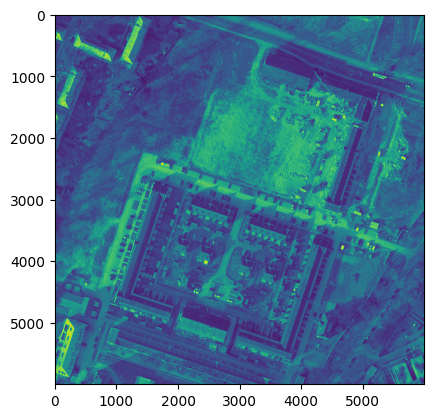

In [3]:
temp_img = cv2.imread("/kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_2_10_RGB.tif") #3 channels / spectral bands

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.suptitle('Channel wise image of the Red, Green & Infrared spectral band')

plt.imshow(temp_img[:,:,2]) #View each channel...
# ax2.imshow(temp_img[:,:,1])
# ax3.imshow(temp_img[:,:,2])

temp_mask = cv2.imread("/kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_2_10_label.tif") #3 channels but all same.
temp_mask_gray = cv2.cvtColor(temp_mask, cv2.COLOR_BGR2GRAY)
# labels, count = np.unique(temp_mask_gray[:,:,0], return_counts=True) #Check for each channel. All chanels are identical


scaling_factor = 5 / 255.0

# Apply the scaling to the image
scaled_mask = temp_mask_gray * scaling_factor

# Convert to integer values
scaled_mask = scaled_mask.astype(np.uint8)


labels2, count2 = np.unique(temp_mask_gray, return_counts=True)
labels, count = np.unique(scaled_mask, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)
print("Labels are: ", labels2, " and the counts are: ", count2)

In [4]:
from pathlib import Path
Path('/kaggle/working/main_folder/512res_patches').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/main_folder/512res_patches/images').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/main_folder/512res_patches/masks').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/main_folder/data_for_training_and_testing').mkdir(parents=True, exist_ok=True)
root_directory = '/kaggle/input/potsdam/Potsdam'
patch_size = 512
img_dir="/kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB"
print("1")

1


In [5]:
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (384, 384, 3), step=512)  #Step=512 for 256 patches means no overlap
            new_name = image_name.replace('_RGB.tif', '')
            
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite("/kaggle/working/main_folder/512res_patches/images/"+
                               new_name+"patch_" + str(i) + str(j) + ".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)


Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_3_14_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_6_7_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_7_9_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_6_11_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_3_11_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_5_15_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_5_10_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_3_13_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_potsdam_2_11_RGB.tif
Now patchifying image: /kaggle/input/potsdam/Potsdam/2_Ortho_RGB/2_Ortho_RGB/top_pot

In [6]:
mask_dir="/kaggle/input/potsdam/Potsdam/5_Labels_all"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (384, 384), step=512)  #Step=256 for 256 patches means no overlap
            new_name2 = mask_name.replace('_label.tif', '')
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite("/kaggle/working/main_folder/512res_patches/masks/"+
                               new_name2+"patch_"+str(i)+str(j)+".tif", single_patch_mask)

Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_9_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_6_15_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_3_10_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_5_12_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_8_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_6_13_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_6_8_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_2_10_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_13_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_7_10_label.tif
Now patchifying mask: /kaggle/input/potsdam/Potsdam/5_Labels_all/top_potsdam_2_13_l

In [7]:
train_img_dir = "/kaggle/working/main_folder/512res_patches/images/"
train_mask_dir = "/kaggle/working/main_folder/512res_patches/masks/"
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
len(msk_list), len(img_list)

(4598, 4598)

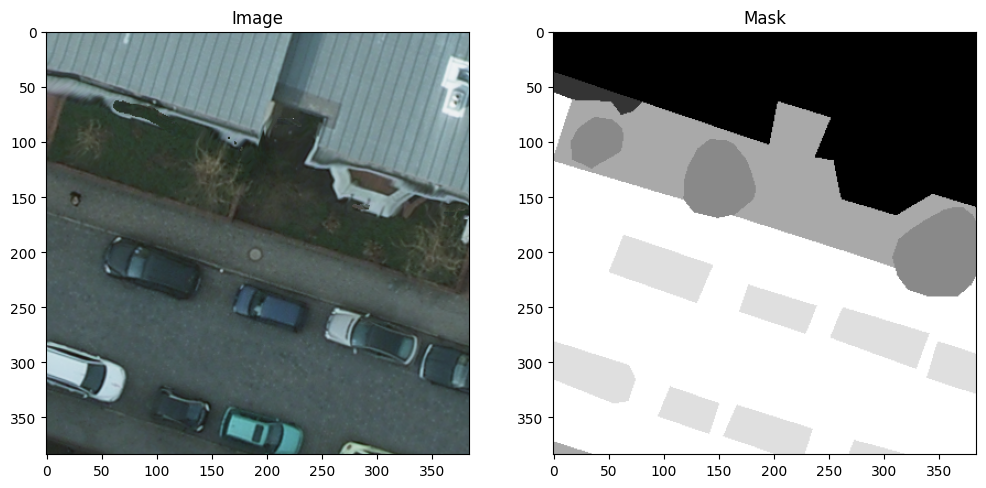

In [8]:
num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [9]:
from keras.utils import normalize
from keras.metrics import MeanIoU
!pip install split-folders

In [10]:
import splitfolders
input_folder = '/kaggle/working/main_folder/512res_patches'
output_folder = '/kaggle/working/main_folder/data_for_training_and_testing'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=32, ratio=(.6, .4), group_prefix=None) # default values

Copying files: 9196 files [00:02, 3939.60 files/s]


In [11]:
!pip install segmentation-models 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 953.1 kB/s eta 0:00:00 0:00:01


In [12]:
# !pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [13]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


#Resizing images, if needed
SIZE_X = 384 
SIZE_Y = 384
n_classes=6 #Number of classes for segmentation


In [14]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/kaggle/working/main_folder/data_for_training_and_testing/val/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/kaggle/working/main_folder/data_for_training_and_testing/val/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0) 
        mask = mask*(5/255)
        mask = mask.astype(np.uint8)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [15]:
train_images.shape, train_masks.shape

((1840, 384, 384, 3), (1840, 384, 384))

In [16]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [17]:
train_images.shape, train_masks_encoded_original_shape.shape

((1840, 384, 384, 3), (1840, 384, 384))

In [18]:
# train_images = np.expand_dims(train_images, axis=3)
# train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
train_images.shape, train_masks_input.shape

((1840, 384, 384, 3), (1840, 384, 384, 1))

In [19]:
# train_images = np.expand_dims(train_images, axis=3)
# train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.10, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3 4 5]


In [20]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [21]:
X_train.shape, y_train_cat.shape

((1490, 384, 384, 3), (1490, 384, 384, 6))

In [22]:
n_classes=6
activation='softmax'

LR = 0.0001
# optim = keras.optimizers.Adam(LR)
optim = "Adam"

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.65528844, 3.56154108, 1.07120728, 0.73141398, 6.44243807,
       0.57563383])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [23]:
BACKBONE = 'resnet50'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train2 = preprocess_input1(X_train)
X_test2 = preprocess_input1(X_test)

In [24]:
# define model
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

94592056/94592056 [==============================] - 0s 0us/step


In [25]:
history=model.fit(X_train2, 
          y_train_cat,
          batch_size=11, 
          epochs=20,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


Epoch 1/20
136/136 [==============================] - 138s 660ms/step - loss: 0.2259 - accuracy: 0.5300 - iou_score: 0.3100 - f1-score: 0.4361 - val_loss: 1.0523 - val_accuracy: 0.2487 - val_iou_score: 0.0667 - val_f1-score: 0.1141
Epoch 2/20
136/136 [==============================] - 78s 577ms/step - loss: -0.0388 - accuracy: 0.5931 - iou_score: 0.4067 - f1-score: 0.5488 - val_loss: 1.0527 - val_accuracy: 0.2613 - val_iou_score: 0.1110 - val_f1-score: 0.1904
Epoch 3/20
136/136 [==============================] - 79s 578ms/step - loss: -0.0501 - accuracy: 0.6130 - iou_score: 0.4188 - f1-score: 0.5604 - val_loss: 0.6809 - val_accuracy: 0.5307 - val_iou_score: 0.2573 - val_f1-score: 0.3745
Epoch 4/20
136/136 [==============================] - 79s 579ms/step - loss: -0.0933 - accuracy: 0.6446 - iou_score: 0.4436 - f1-score: 0.5858 - val_loss: 0.9240 - val_accuracy: 0.3559 - val_iou_score: 0.1487 - val_f1-score: 0.2355
Epoch 5/20
136/136 [==============================] - 79s 579ms/step - l

In [26]:
model.save('LinkNet_384_res50_backbone_20epochs.hdf5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Evaluate the model on the test set
evaluation = model.evaluate(x=X_test2, y= y_test_cat, batch_size=8)

# Extract the accuracy from the evaluation
accuracy = evaluation[1] * 100  # Assuming accuracy is the second metric

# Print the accuracy
print(f"Test set accuracy: {accuracy:.2f}%")

23/23 [==============================] - 3s 124ms/step - loss: -0.1493 - accuracy: 0.7166 - iou_score: 0.5068 - f1-score: 0.6333
Test set accuracy: 71.66%


In [28]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

6/6 [==============================] - 18s 2s/step
Mean IoU = 0.48212162


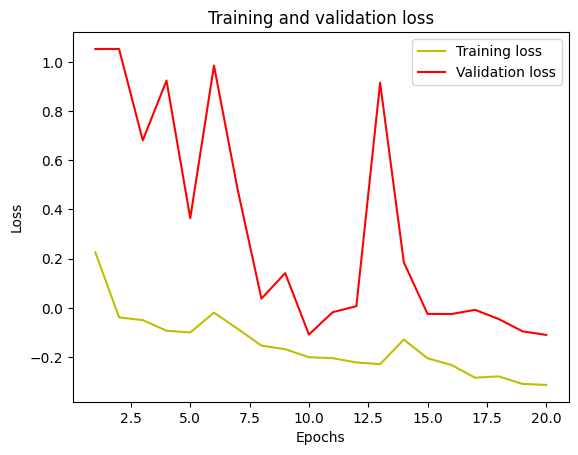

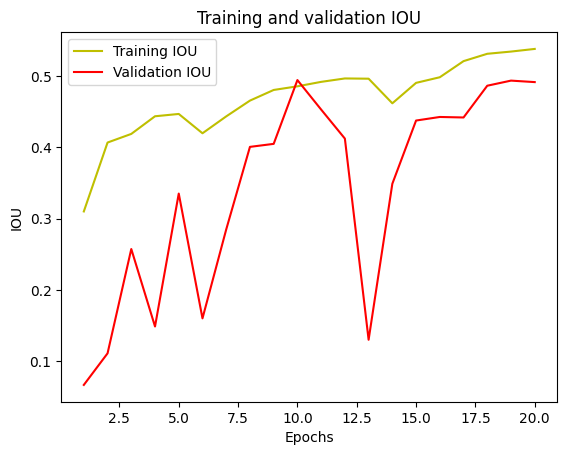

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [30]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[0,5]+ values[1,5]+ values[2,5])

print("IoU for class1: Building is: ", class1_IoU)
print("IoU for class2: Impervious Surface is: ", class2_IoU)
print("IoU for class3: Trees is: ", class3_IoU)
print("IoU for class4: Low Vegetation is: ", class4_IoU)
print("IoU for class5: Car is: ", class5_IoU)
print("IoU for class6: Clutter/Background is: ", class6_IoU)

[[6.213512e+06 7.343080e+05 1.518460e+05 3.139290e+05 2.920000e+02
  3.211500e+05]
 [3.086520e+05 4.199080e+05 1.092290e+05 3.395570e+05 3.410000e+03
  2.181380e+05]
 [2.528700e+04 3.409200e+04 3.403984e+06 2.619700e+05 6.761000e+03
  1.620210e+05]
 [1.044310e+05 1.581590e+05 1.565492e+06 3.957364e+06 2.008500e+04
  1.651030e+05]
 [4.640500e+04 5.356300e+04 1.318700e+04 1.331700e+04 2.809330e+05
  2.974930e+05]
 [8.706050e+05 3.745640e+05 4.276770e+05 5.701400e+05 1.768200e+04
  5.167658e+06]]
IoU for class1: Building is:  0.7913321
IoU for class2: Impervious Surface is:  0.19958505
IoU for class3: Trees is:  0.61312056
IoU for class4: Low Vegetation is:  0.5905718
IoU for class5: Car is:  0.6944316
IoU for class6: Clutter/Background is:  0.68520105


1/1 [==============================] - 1s 1s/step


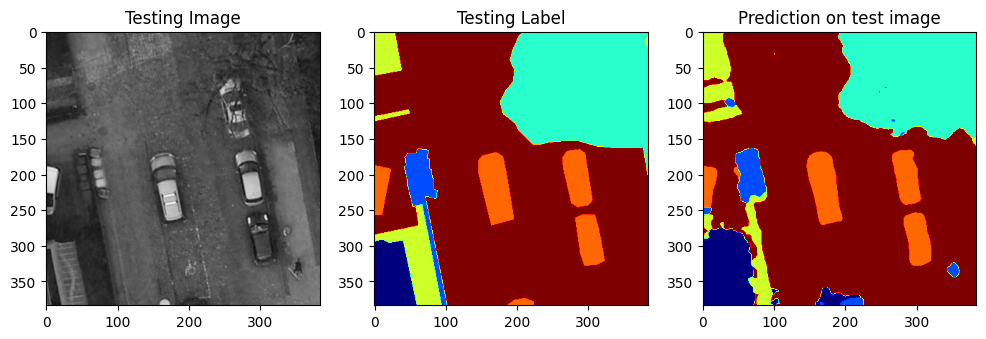

In [31]:
import random
test_img_number = 6
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()